# Topic Modeling: Latent Dirichlet Allocation with gensim

Gensim is a specialized NLP library with a fast LDA implementation and many additional features. We will also use it in the next chapter on word vectors (see the notebook lda_with_gensim for details.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import pandas as pd

# Visualization
import seaborn as sns
import pyLDAvis

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import joblib

# gensim for alternative models
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
sns.set_style('white')
pyLDAvis.enable_notebook()

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load BBC data

In [4]:
# change to your data path if necessary
DATA_DIR = Path('../data')

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
path = DATA_DIR / 'bbc'
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Convert to DataFrame

In [6]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   article  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create Train & Test Sets

In [7]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
train_docs.shape, test_docs.shape

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((2175, 3), (50, 3))

In [9]:
pd.Series(test_docs.topic).value_counts()

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: topic, dtype: int64

### Vectorize train & test sets

In [10]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 179068 stored elements in Compressed Sparse Row format>

In [11]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 4150 stored elements in Compressed Sparse Row format>

## LDA with gensim

### Using `CountVectorizer` Input

In [12]:
max_df = .2
min_df = 3
max_features = 2000

# used by sklearn: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None, 
                         squeeze=True).tolist()

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
vectorizer = CountVectorizer(max_df=max_df, 
                             min_df=min_df, 
                             stop_words='english', 
                             max_features=max_features)

train_dtm = vectorizer.fit_transform(train_docs.article)
test_dtm = vectorizer.transform(test_docs.article)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Convert sklearn DTM to gensim data structures

It faciltiates the conversion of DTM produced by sklearn to gensim data structures as follows:

In [14]:
train_corpus = Sparse2Corpus(train_dtm, documents_columns=False)
test_corpus = Sparse2Corpus(test_dtm, documents_columns=False)
id2word = pd.Series(vectorizer.get_feature_names()).to_dict()

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Train Model & Review Results

In [15]:
LdaModel(corpus=train_corpus, 
         num_topics=100, 
         id2word=None, 
         distributed=False, 
         chunksize=2000,                   # Number of documents to be used in each training chunk.
         passes=1,                         # Number of passes through the corpus during training
         update_every=1,                   # Number of docs to be iterated through for each update
         alpha='symmetric', 
         eta=None,                         # a-priori belief on word probability
         decay=0.5,                        # percentage of previous lambda forgotten when new document is examined
         offset=1.0,                       # controls slow down of the first steps the first few iterations.
         eval_every=10,                    # estimate log perplexity
         iterations=50,                    # Maximum number of iterations through the corpus
         gamma_threshold=0.001,            # Minimum change in the value of the gamma parameters to continue iterating
         minimum_probability=0.01,         # Topics with a probability lower than this threshold will be filtered out
         random_state=None, 
         ns_conf=None, 
         minimum_phi_value=0.01,           # if `per_word_topics` is True, represents lower bound on term probabilities
         per_word_topics=False,            #  If True, compute a list of most likely topics for each word with phi values multiplied by word count
         callbacks=None);

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
num_topics = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, num_topics+1)]

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
lda_gensim = LdaModel(corpus=train_corpus,
                      num_topics=num_topics,
                      id2word=id2word)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
topics = lda_gensim.print_topics()
topics[0]

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0,
 '0.007*"company" + 0.005*"party" + 0.005*"best" + 0.004*"says" + 0.004*"group" + 0.004*"film" + 0.004*"court" + 0.004*"games" + 0.004*"legal" + 0.003*"oil"')

### Evaluate Topic Coherence

Topic Coherence measures whether the words in a topic tend to co-occur together. 

- It adds up a score for each distinct pair of top ranked words. 
- The score is the log of the probability that a document containing at least one instance of the higher-ranked word also contains at least one instance of the lower-ranked word.

Large negative values indicate words that don't co-occur often; values closer to zero indicate that words tend to co-occur more often.

In [19]:
coherence = lda_gensim.top_topics(corpus=train_corpus, coherence='u_mass')

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Gensim permits topic coherence evaluation that produces the topic coherence and shows the most important words per topic: 

  Topic 1           Topic 2         Topic 3          Topic 4        Topic 5         
     prob      term    prob    term    prob     term    prob   term    prob     term
0   1.10%    labour   0.91%  mobile   0.70%  company   0.77%   game   0.62%  england
1   0.80%  election   0.64%   games   0.55%    party   0.69%  sales   0.56%     best
2   0.75%     blair   0.57%     web   0.46%     best   0.55%  games   0.52%      win
3   0.69%     brown   0.53%  search   0.42%     says   0.47%   deal   0.50%      won
4   0.60%    howard   0.52%     net   0.41%    group   0.45%   good   0.41%     team


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


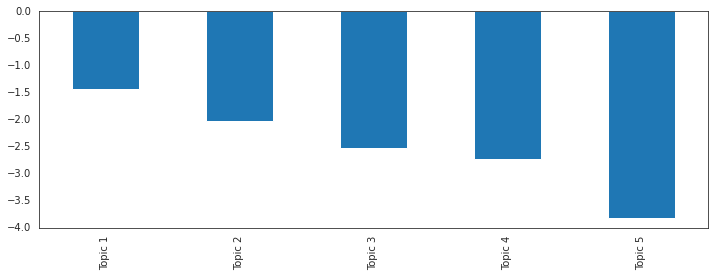

In [20]:
topic_coherence = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)
                      
topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False)
topic_words.head().to_csv('topic_words.csv', index=False)
print(topic_words.head())

pd.Series(topic_coherence, index=topic_labels).plot.bar(figsize=(12,4));

### Using `gensim` `Dictionary` 

In [21]:
docs = [d.split() for d in train_docs.article.tolist()]
docs = [[t for t in doc if t not in stop_words] for doc in docs]

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2000
Number of documents: 2175


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = None # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes, 
                 eval_every=eval_every)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
model.show_topics()

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.012*"best" + 0.007*"film" + 0.007*"won" + 0.007*"win" + 0.006*"game" + 0.006*"England" + 0.005*"play" + 0.005*"good" + 0.005*"think" + 0.005*"second"'),
 (1,
  '0.021*"Labour" + 0.017*"Blair" + 0.015*"election" + 0.013*"Brown" + 0.012*"Lord" + 0.012*"party" + 0.011*"Howard" + 0.011*"Tory" + 0.010*"prime" + 0.008*"public"'),
 (2,
  '0.012*"government" + 0.005*"European" + 0.005*"legal" + 0.005*"says" + 0.005*"public" + 0.005*"Ms" + 0.005*"money" + 0.005*"EU" + 0.004*"work" + 0.004*"law"'),
 (3,
  '0.010*"mobile" + 0.009*"technology" + 0.008*"games" + 0.008*"music" + 0.007*"use" + 0.007*"users" + 0.007*"phone" + 0.006*"used" + 0.006*"net" + 0.006*"video"'),
 (4,
  '0.010*"company" + 0.009*"sales" + 0.009*"market" + 0.009*"growth" + 0.008*"economic" + 0.007*"rise" + 0.007*"oil" + 0.007*"economy" + 0.007*"firm" + 0.006*"chief"')]

### Evaluating Topic Assignments on the Test Set

In [28]:
docs_test = [d.split() for d in test_docs.article.tolist()]
docs_test = [[t for t in doc if t not in stop_words] for doc in docs_test]

test_dictionary = Dictionary(docs_test)
test_dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)
test_corpus = [dictionary.doc2bow(doc) for doc in docs_test]

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
gamma, _ = model.inference(test_corpus)
topic_scores = pd.DataFrame(gamma)
topic_scores.head(10)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4
0,19.146658,0.051314,0.139427,17.055145,0.093734
1,2.964511,3.631570,5.128225,157.635162,0.093728
2,2.437624,0.051314,38.566299,40.330196,0.093719
3,0.141710,0.051314,27.128258,9.319160,19.845629
4,86.310379,0.051314,2.145877,0.072351,2.894809
5,5.462916,0.051314,11.964343,0.072351,39.932270
6,16.709969,0.051314,26.629995,0.072351,87.001869
7,84.127693,0.051314,0.139049,0.072351,0.093723
8,0.141705,1.410880,0.139311,1.598531,134.170822
9,0.141487,0.051314,12.392625,2.545936,30.358202


In [30]:
topic_probabilities = topic_scores.div(topic_scores.sum(axis=1), axis=0)
topic_probabilities.head()

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4
0,0.524763,0.001406,0.003821,0.467440,0.002569
1,0.017495,0.021431,0.030263,0.930258,0.000553
2,0.029917,0.000630,0.473327,0.494976,0.001150
3,0.002509,0.000908,0.480265,0.164982,0.351337
4,0.943543,0.000561,0.023459,0.000791,0.031646


In [31]:
topic_probabilities.idxmax(axis=1).head()

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    0
1    3
2    3
3    2
4    0
dtype: int64

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


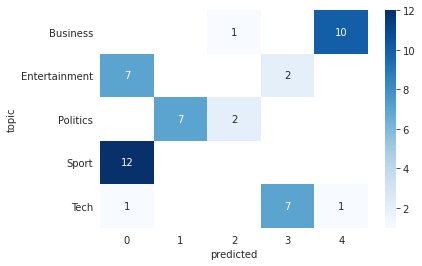

In [32]:
predictions = test_docs.topic.to_frame('topic').assign(predicted=topic_probabilities.idxmax(axis=1).values)
heatmap_data = predictions.groupby('topic').predicted.value_counts().unstack()
sns.heatmap(heatmap_data, annot=True, cmap='Blues');

## Resources

- pyLDAvis: 
    - [Talk by the Author](https://speakerdeck.com/bmabey/visualizing-topic-models) and [Paper by (original) Author](http://www.aclweb.org/anthology/W14-3110)
    - [Documentation](http://pyldavis.readthedocs.io/en/latest/index.html)
- LDA:
    - [David Blei Homepage @ Columbia](http://www.cs.columbia.edu/~blei/)
    - [Introductory Paper](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf) and [more technical review paper](http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf)
    - [Blei Lab @ GitHub](https://github.com/Blei-Lab)
    
- Topic Coherence:
    - [Exploring Topic Coherence over many models and many topics](https://www.aclweb.org/anthology/D/D12/D12-1087.pdf)
    - [Paper on various Methods](http://www.aclweb.org/anthology/N10-1012)
    - [Blog Post - Overview](http://qpleple.com/topic-coherence-to-evaluate-topic-models/)
